In [217]:
from data import get_seizure_data
cases = ["chb01", "chb02", "chb03", "chb04", "chb05", "chb06", "chb07", "chb08", "chb09", "chb10", "chb11", "chb12", "chb13", "chb14", "chb15", "chb16", "chb17", "chb18", "chb19", "chb20", "chb21", "chb22", "chb23", "chb24"]
for case in cases:
    datas = get_seizure_data(case)
    case_seizure_count = 0
    for data in datas:
        case_seizure_count += data.seizure_count
    print(case, case_seizure_count)

chb01 7
chb02 3
chb03 7
chb04 4
chb05 5
chb06 9
chb07 2
chb08 5
chb09 3
chb10 6
chb11 2
chb12 35
chb13 9
chb14 8
chb15 20
chb16 10
chb17 3
chb18 5
chb19 2
chb20 7
chb21 4
chb22 3
chb23 7
chb24 16


In [1]:
# return to chb04, 07, really struggling for some reason
# chb15 corrupt
# revisit chb22, one FP
case = "chb24"

In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
from keras import backend as keras
from tensorflow import keras

import numpy as np
import os

In [205]:
# test_cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb01" in x or "chb02" in x or "chb03" in x or "chb04" in x or "chb05" in x or "chb06" in x or "chb07" in x or "chb08" in x]
# test_cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if "chb02" in x or "chb03" in x or "chb04" in x or "chb05" in x or "chb07" in x or "chb08" in x or "chb09" in x]
# cases = [x for x in os.listdir("dataset/chb-mit-scalp-eeg-database-1.0.0/") if not "chb01" in x and "chb" in x]

In [2]:
from seizure_sequence import SeizureSequence
seizure_sequence_balanced = SeizureSequence(1, "ml_processed_balanced_pre_ictal", case, bias_positive=False)
whole_file_sequence = SeizureSequence(1, "ml_processed_pre_ictal", case, bias_positive=False)

In [3]:
from model import create_model, create_large_model, compile_model
model = compile_model(create_model())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 512)           393728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 256)            393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 128)            98432     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 128)           0

In [4]:
# history_with_whole_file = model.fit(whole_file_sequence, epochs=1)
history = model.fit(seizure_sequence_balanced, epochs=200)

Epoch 1/200
23/23 [==============================] - 2s 12ms/step - loss: 0.6893 - accuracy: 0.5662
Epoch 2/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.5671
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5671
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.5671
Epoch 5/200
23/23 [==============================] - 0s 7ms/step - loss: 0.6861 - accuracy: 0.5671
Epoch 6/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.5671
Epoch 7/200
23/23 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5671
Epoch 8/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.5671
Epoch 9/200
23/23 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5671
Epoch 10/200
23/23 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.5671
Epoch 11

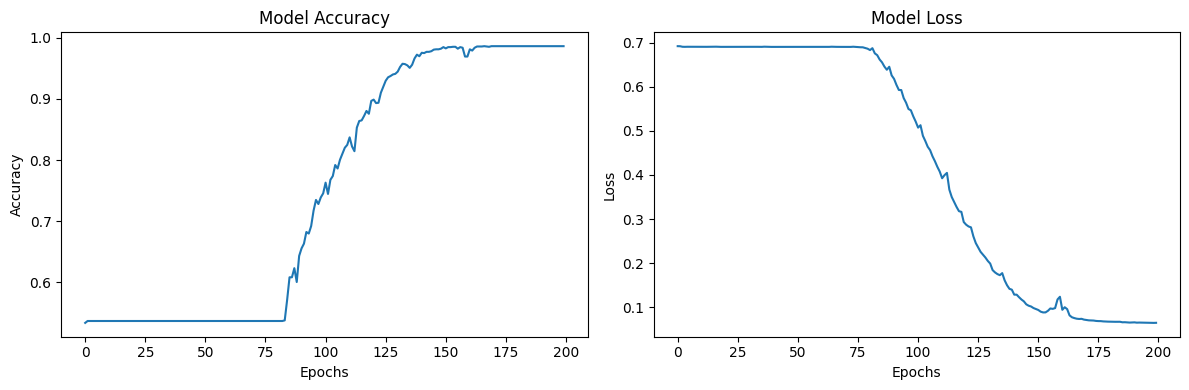

In [209]:
from model import accuracy_loss_plot
accuracy_loss_plot(history)

# combined_history = {}
# for key in history.history.keys():
#     # combined_history[key] = history.history[key] + history_with_whole_file.history[key]
#     combined_history[key] = history_with_whole_file.history[key] + history.history[key]

    
# accuracy_loss_plot(combined_history, combined=True)

In [210]:
print(seizure_sequence_balanced.get_test_file())

chb12_06.edf_pre_ictal


In [211]:
file = seizure_sequence_balanced.get_test_file()
whole_file_data = np.load("ml_processed_pre_ictal/" + file + "_data.npy")
whole_file_labels = np.load("ml_processed_pre_ictal/" + file + "_labels.npy")
# whole_file_labels = np.load("ml_processed/chb04_08.edf_labels.npy")
# whole_file_labels = np.load("ml_processed/chb04_08.edf_labels.npy")

print(whole_file_data.shape)
predictions = model.predict(whole_file_data)

threshold = 0.9
best_threshold = threshold
best_accuracy = 0
lowest_false_neg = float('inf')
detail = 10
for i in range(0, 101):
    false_pos = 0
    true_pos = 0
    false_neg = 0
    true_neg = 0
    for i, prediction in enumerate(predictions):
        p = prediction[0][0]
        # if p == 1:
        if p > threshold:
            if whole_file_labels[i] == 0:
                false_pos += 1
            else:
                true_pos += 1
        else:
            if whole_file_labels[i] == 1:
                false_neg += 1
            else:
                true_neg += 1
    whole_file_accuracy = ((true_pos + true_neg) / whole_file_data.shape[0]) * 100
    if false_neg <= lowest_false_neg and true_pos > 0 and whole_file_accuracy > best_accuracy:
        lowest_false_neg = false_neg
        best_accuracy = whole_file_accuracy
        best_threshold = threshold
    threshold = round(threshold + 0.001, 3)

# print(f"Best threshold: {best_threshold}\nBest accuracy: {best_accuracy} \nLowest false neg: {lowest_false_neg}")



false_pos = 0
true_pos = 0
false_neg = 0
true_neg = 0
for i, prediction in enumerate(predictions):
    p = prediction[0][0]
    # if p == 1:
    if p > best_threshold:
        if whole_file_labels[i] == 0:
            false_pos += 1
        else:
            true_pos += 1
    else:
        if whole_file_labels[i] == 1:
            false_neg += 1
        else:
            true_neg += 1
whole_file_accuracy = ((true_pos + true_neg) / whole_file_data.shape[0]) * 100
print("\t false", "\t", "true")
print("pos \t", false_pos, "\t", true_pos)
print("neg \t", false_neg, "\t", true_neg)
print(f"\nBest Threshold: {best_threshold}, Correct: {round(whole_file_accuracy, 2)}%")

if True and false_neg == 0:
    model.save("models/" + case + "_threshold_" + str(best_threshold) + "_accuracy_" + str(round(best_accuracy)) + ".h5")

(3550, 23, 256)
111/111 [==============================] - 0s 2ms/step
	 false 	 true
pos 	 1275 	 78
neg 	 0 	 2197

Best Threshold: 0.945, Correct: 64.08%


In [212]:
# model.save("models/" + case + "_threshold_" + str(best_threshold) + "_accuracy_" + str(best_accuracy) + ".h5")
# # model.save("models/" + case + "_whole_file_trained_" + str(whole_file_accuracy) + ".h5")